In [0]:
import os
import sys
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,SpatialDropout1D,Convolution1D,GlobalMaxPool1D,GlobalAveragePooling1D,CuDNNGRU
from keras.layers import Conv1D, MaxPooling1D, Embedding,Dropout,Flatten,concatenate
from sklearn.preprocessing import LabelEncoder
from keras.models import Model

In [5]:
!wget https://s3.us-east-2.amazonaws.com/audiosamplesyk/train.csv
!wget https://s3.us-east-2.amazonaws.com/audiosamplesyk/test.csv
!wget https://s3.us-east-2.amazonaws.com/audiosamplesyk/samplesubmission.csv 


Redirecting output to ‘wget-log’.

Redirecting output to ‘wget-log.1’.

Redirecting output to ‘wget-log.2’.


In [0]:
#############Train,test and submission##################################
df_woc = pd.read_csv('train.csv',index_col=False)
df_test = pd.read_csv('test.csv',index_col=False)
df_woc_submission = pd.read_csv('samplesubmission.csv',index_col=False)

df_woc.converse=df_woc.converse.astype(str)
df_test.converse=df_test.converse.astype(str)


In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]



In [0]:
df_woc['converse'] = df_woc['converse'].map(lambda x: lemmatize_text(x))

df_test['converse'] = df_test['converse'].map(lambda x: lemmatize_text(x))

In [0]:
df_woc['converse'] = df_woc['converse'].map(lambda x: clean_doc(x))

In [7]:
!wget https://s3.amazonaws.com/audiosampleyug/glove.6B.100d.txt 


Redirecting output to ‘wget-log.3’.


In [92]:
########################Using glove vector#####################################################3

MAX_NUM_WORDS=20000
max_len=1000
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
nb_epochs = 50
num_words = min(MAX_NUM_WORDS, len(word_index))

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')


Indexing word vectors.
Found 400000 word vectors.
Processing text dataset


In [93]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df_woc.converse)
sequences = tokenizer.texts_to_sequences(df_woc.converse)

tokenizer.fit_on_texts(df_test.converse)
sequences_test = tokenizer.texts_to_sequences(df_test.converse)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
text_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
text_seq_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)


Found 37150 unique tokens.


In [95]:
text_seq

array([[   0,    0,    0, ...,  263,  256,  110],
       [   0,    0,    0, ...,    1,  460,   46],
       [   0,    0,    0, ...,  192,    1,  391],
       ...,
       [   0,    0,    0, ...,  575,   46,   25],
       [   0,    0,    0, ...,   76,  645,   23],
       [   0,    0,    0, ..., 1739,  150,  239]], dtype=int32)

In [96]:
##########################Encoding target##################################################
from keras.utils import to_categorical
encoder = LabelEncoder()
trafomed_label = encoder.fit_transform(df_woc.categories)
print(trafomed_label)

labels = to_categorical(np.asarray(trafomed_label))
print(labels)

[1 1 4 ... 4 4 4]
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [0]:
####################3Splitting train data###############################################3
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(text_seq, labels)

In [0]:
text_seq.shape[0]

45825

In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [98]:
embedding_layer

## LSTM CUDNN

In [105]:
score = model_lstm.evaluate(text_seq, labels, batch_size=128, verbose=1)

45825/45825 [==============================] - 92s 2ms/step


In [106]:
score

[0.505109828344246, 0.808379705400982]

In [0]:
score = model1.evaluate(x_test, y_test, batch_size=128, verbose=1)

11457/11457 [==============================] - 2s 178us/step


In [0]:
score

[1.8602066257398062, 0.7515056298188413]

In [0]:
preds_test = model_lstm.predict(text_seq_test,verbose=5)

In [109]:
preds_test[0]

array([3.7043389e-02, 3.2965928e-01, 6.3184857e-06, 1.1714890e-03,
       2.5654476e-02, 6.0646510e-01], dtype=float32)

In [0]:
encoder.classes_

array(['APPOINTMENTS', 'ASK_A_DOCTOR', 'JUNK', 'LAB', 'MISCELLANEOUS',
       'PRESCRIPTION'], dtype=object)

In [0]:
text_labels=encoder.classes_

In [0]:
text_labels

array(['APPOINTMENTS', 'ASK_A_DOCTOR', 'JUNK', 'LAB', 'MISCELLANEOUS',
       'PRESCRIPTION'], dtype=object)

In [110]:
predicted_label=[]

for i in preds_test:
    print(i)
    predicted_label.append(text_labels[np.argmax(i)])

[3.7043389e-02 3.2965928e-01 6.3184857e-06 1.1714890e-03 2.5654476e-02
 6.0646510e-01]
[2.7236748e-03 9.5730019e-01 3.4482739e-06 3.2285514e-04 1.5841125e-02
 2.3808697e-02]
[3.1468403e-02 5.0909376e-01 6.0169932e-05 7.0884628e-03 4.4515941e-01
 7.1297614e-03]
[2.4614826e-02 3.4307519e-01 3.4455126e-05 3.5522975e-02 2.4734125e-01
 3.4941125e-01]
[5.0737509e-03 1.4095392e-02 4.3516120e-05 8.4265107e-01 1.3294087e-01
 5.1954561e-03]
[3.7177317e-05 1.8589256e-02 9.9934645e-08 8.0675381e-05 2.0996556e-03
 9.7919321e-01]
[1.4250042e-04 5.4741879e-03 2.2798338e-06 4.4621379e-04 1.7156294e-02
 9.7677851e-01]
[0.06354598 0.06458718 0.00069887 0.1310679  0.6550745  0.08502561]
[9.9911898e-01 4.0101375e-05 4.9225978e-06 1.0789717e-04 6.8823813e-04
 3.9871618e-05]
[2.0879013e-02 5.4620355e-01 2.8019300e-05 1.9261517e-02 3.7949401e-01
 3.4133919e-02]
[7.4326509e-01 8.2586296e-03 2.0869658e-05 1.9283524e-03 2.3376222e-01
 1.2764883e-02]
[3.1136483e-02 4.1600224e-01 1.0192345e-05 8.7538833e-04 3.256

In [111]:
predicted_label

['PRESCRIPTION',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'LAB',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'LAB',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'LAB',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'LAB',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 

In [0]:
df_woc_submission.categories=predicted_label

In [0]:
df_woc_submission.to_csv("submission_lstm.csv", index=False)

In [0]:
from google.colab import files
files.download('submission_lstm.csv') 

In [114]:
df_woc_submission

,ID,categories
0,1,PRESCRIPTION
1,4,ASK_A_DOCTOR
2,7,ASK_A_DOCTOR
3,13,PRESCRIPTION
4,18,LAB
5,26,PRESCRIPTION
6,39,PRESCRIPTION
7,43,MISCELLANEOUS
8,53,APPOINTMENTS
9,63,ASK_A_DOCTOR


In [0]:
from google.colab import files
files.upload()

Saving submission_.csv to submission_.csv


{'submission_.csv': b'ID,categories\r\n1,ASK_A_DOCTOR\r\n4,ASK_A_DOCTOR\r\n7,ASK_A_DOCTOR\r\n13,ASK_A_DOCTOR\r\n18,MISCELLANEOUS\r\n26,PRESCRIPTION\r\n39,PRESCRIPTION\r\n43,LAB\r\n53,APPOINTMENTS\r\n63,ASK_A_DOCTOR\r\n64,APPOINTMENTS\r\n67,ASK_A_DOCTOR\r\n89,APPOINTMENTS\r\n95,ASK_A_DOCTOR\r\n102,MISCELLANEOUS\r\n104,ASK_A_DOCTOR\r\n107,PRESCRIPTION\r\n111,ASK_A_DOCTOR\r\n114,MISCELLANEOUS\r\n117,MISCELLANEOUS\r\n118,PRESCRIPTION\r\n128,ASK_A_DOCTOR\r\n142,LAB\r\n154,APPOINTMENTS\r\n155,ASK_A_DOCTOR\r\n164,ASK_A_DOCTOR\r\n165,MISCELLANEOUS\r\n175,APPOINTMENTS\r\n176,ASK_A_DOCTOR\r\n178,APPOINTMENTS\r\n186,MISCELLANEOUS\r\n195,ASK_A_DOCTOR\r\n198,ASK_A_DOCTOR\r\n199,PRESCRIPTION\r\n200,MISCELLANEOUS\r\n201,ASK_A_DOCTOR\r\n224,MISCELLANEOUS\r\n228,PRESCRIPTION\r\n229,APPOINTMENTS\r\n236,PRESCRIPTION\r\n239,APPOINTMENTS\r\n242,APPOINTMENTS\r\n243,ASK_A_DOCTOR\r\n246,APPOINTMENTS\r\n247,APPOINTMENTS\r\n262,MISCELLANEOUS\r\n263,PRESCRIPTION\r\n266,APPOINTMENTS\r\n274,PRESCRIPTION\r\n282,LAB

In [0]:
df_woc_submission_old = pd.read_csv('submission_.csv',index_col=False)


In [0]:
df_woc_submission_old


trafomed_label_old = encoder.fit_transform(df_woc_submission_old.categories)
print(trafomed_label_old)

labels_old = to_categorical(np.asarray(trafomed_label_old))
print(labels_old)

#model1.evaluate(text_seq_test, df_woc_submission_old, batch_size=128, verbose=1)

[1 1 1 ... 5 5 1]
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


In [0]:
df_woc_submission_old.categories

0         ASK_A_DOCTOR
1         ASK_A_DOCTOR
2         ASK_A_DOCTOR
3         ASK_A_DOCTOR
4        MISCELLANEOUS
5         PRESCRIPTION
6         PRESCRIPTION
7                  LAB
8         APPOINTMENTS
9         ASK_A_DOCTOR
10        APPOINTMENTS
11        ASK_A_DOCTOR
12        APPOINTMENTS
13        ASK_A_DOCTOR
14       MISCELLANEOUS
15        ASK_A_DOCTOR
16        PRESCRIPTION
17        ASK_A_DOCTOR
18       MISCELLANEOUS
19       MISCELLANEOUS
20        PRESCRIPTION
21        ASK_A_DOCTOR
22                 LAB
23        APPOINTMENTS
24        ASK_A_DOCTOR
25        ASK_A_DOCTOR
26       MISCELLANEOUS
27        APPOINTMENTS
28        ASK_A_DOCTOR
29        APPOINTMENTS
             ...      
11425     PRESCRIPTION
11426    MISCELLANEOUS
11427     PRESCRIPTION
11428     PRESCRIPTION
11429     APPOINTMENTS
11430     APPOINTMENTS
11431     APPOINTMENTS
11432     PRESCRIPTION
11433    MISCELLANEOUS
11434    MISCELLANEOUS
11435     APPOINTMENTS
11436     PRESCRIPTION
11437      

In [0]:
predicted_label

['MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'LAB',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'LAB',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'LAB',


In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(df_woc_submission_old.categories, predicted_label)

0.5632474901789611

## LSTM - GLOVE Vectors

In [103]:
print('Training model.')

from keras.layers import CuDNNLSTM, Dropout
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
Y=Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)
x=Y(sequence_input)
#z = Dropout(0.2)(embedded_sequences)
x = Dropout(0.3)(x) 
#z=CuDNNGRU(16, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal')(x)
z = CuDNNLSTM(512)(x)
#z = CuDNNLSTM(512)(z)
preds_lstm = Dense(6, activation='softmax')(z)


from keras.optimizers import Adam
model_lstm = Model(sequence_input, preds_lstm)
model_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Training model.


In [22]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               117760    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 2,118,534
Trainable params: 118,534
Non-trainable params: 2,000,000
_________________________________________________________________


In [104]:
model_lstm_hist = model_lstm.fit(text_seq, labels,
                  batch_size=256,
                  epochs=50).history

Epoch 1/50
45825/45825 [==============================] - 237s 5ms/step - loss: 1.3815 - acc: 0.4260
Epoch 2/50
45825/45825 [==============================] - 238s 5ms/step - loss: 1.1827 - acc: 0.5285
Epoch 3/50
45825/45825 [==============================] - 238s 5ms/step - loss: 0.9220 - acc: 0.6555
Epoch 4/50
45825/45825 [==============================] - 236s 5ms/step - loss: 0.7999 - acc: 0.7015
Epoch 5/50
45825/45825 [==============================] - 237s 5ms/step - loss: 0.7311 - acc: 0.7294
Epoch 6/50
45825/45825 [==============================] - 237s 5ms/step - loss: 0.6790 - acc: 0.7471
Epoch 7/50
45825/45825 [==============================] - 236s 5ms/step - loss: 0.6937 - acc: 0.7456
Epoch 8/50
45825/45825 [==============================] - 237s 5ms/step - loss: 0.6389 - acc: 0.7649
Epoch 9/50
45825/45825 [==============================] - 238s 5ms/step - loss: 0.6705 - acc: 0.7485
Epoch 10/50
45825/45825 [==============================] - 237s 5ms/step - loss: 0.6130 - a

KeyboardInterrupt: ignored

In [62]:
model_lstm_hist['acc']

[0.4993998908892526,
 0.6071358428805237,
 0.6547954173486088,
 0.7123186033824331,
 0.735646481178396,
 0.7489361702127659,
 0.7556137479541735,
 0.7662629569012548,
 0.770430987452264,
 0.7753627932351337,
 0.7479759956355702,
 0.776606655755592,
 0.7769776322967812,
 0.7844626295690126,
 0.7869939989088925,
 0.7940207310420077,
 0.7936061102018549,
 0.7951118385160938,
 0.785771958537916,
 0.7961811238406983,
 0.8027932351336606,
 0.7952209492635025,
 0.8015057283142389,
 0.8079214402618657,
 0.8087070376432078,
 0.8111947626841244,
 0.8118494271685761,
 0.8086852154937262,
 0.8145771958537916,
 0.8179378068739771,
 0.8195962902345881,
 0.820316421167485,
 0.8249208947081288,
 0.8237861429350791,
 0.8274959083469722,
 0.8282160392798691,
 0.8293944353518822,
 0.8250081833060556,
 0.8330823786142935,
 0.8324713584288053,
 0.8175668303327878,
 0.8318385160938352,
 0.8348281505728314,
 0.8282378614293507,
 0.8296563011456628,
 0.7864266230223677,
 0.8209274413529732,
 0.829307146753955

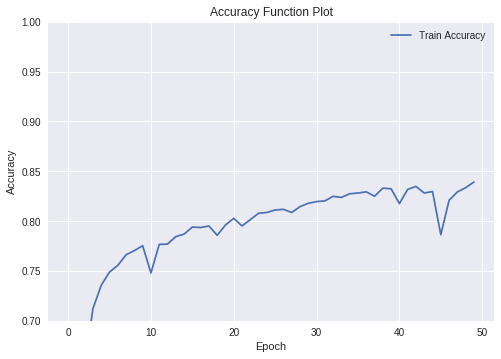

In [63]:
import matplotlib.pyplot as plt
plt.plot(model_lstm_hist['acc'])
#plt.plot(model_lstm_hist.history['val_acc'])
plt.title('Accuracy Function Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7,1)
plt.legend(['Train Accuracy'])
plt.show()

In [0]:
model_lstm.save('LSTM_61')

In [0]:
from google.colab import files
files.download('LSTM_61')

In [49]:
model_lstm.evaluate(text_seq, labels)

45825/45825 [==============================] - 86s 2ms/step


[0.3968857547699535, 0.8431423895253682]

In [50]:
preds_test = model_lstm.predict(text_seq_test,verbose=1)

11455/11455 [==============================] - 21s 2ms/step


In [0]:
df_woc_submission = pd.read_csv('samplesubmission.csv',index_col=False)


In [0]:
text_labels=encoder.classes_

In [53]:
predicted_label=[]
for i in preds_test:
    print(i)
    predicted_label.append(text_labels[np.argmax(i)])

[3.26365411e-01 1.02667816e-01 3.40017982e-06 3.07004969e-03
 1.30473658e-01 4.37419713e-01]
[9.7025316e-03 8.8255531e-01 9.3605342e-07 5.9578416e-04 1.0651107e-01
 6.3433178e-04]
[7.8673027e-03 7.7261621e-01 5.4449652e-06 1.0494940e-02 2.0018534e-01
 8.8308435e-03]
[4.8227381e-02 5.6583184e-01 9.2246692e-06 2.2676852e-02 2.6092565e-01
 1.0232905e-01]
[2.2054112e-03 9.3204860e-04 8.8113012e-07 1.1468802e-02 9.8524404e-01
 1.4880045e-04]
[2.5490604e-05 2.5238143e-03 1.3821607e-07 1.7638447e-05 5.8739991e-03
 9.9155891e-01]
[4.8070838e-06 4.4729230e-05 6.3598145e-07 2.0004243e-05 2.0898413e-03
 9.9783993e-01]
[8.9758160e-03 3.2922797e-02 7.5084550e-05 2.2521127e-02 9.2664731e-01
 8.8578193e-03]
[9.5105171e-01 1.2441423e-03 1.5655707e-05 7.4085739e-04 2.9959640e-02
 1.6987927e-02]
[1.3583141e-02 1.5271270e-01 2.1477379e-06 7.5600702e-01 7.5912885e-02
 1.7819871e-03]
[5.4061621e-01 7.0344252e-03 4.7387234e-06 1.1635582e-02 4.3832844e-01
 2.3805804e-03]
[1.1915131e-02 7.1631342e-01 2.079122

In [54]:
predicted_label

['PRESCRIPTION',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'LAB',
 'APPOINTMENTS',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'LAB',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'LAB',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'PRESCRIPTION',
 'PRESCRIPTION',
 'APPOINTMENTS',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'MISCELLANEOUS',
 'PRESCRIPTION',
 'ASK_A_DOCTOR',
 'LAB',
 'PRESCRIPTION',
 'MISCELLANEOUS',
 'ASK_A_DOCTOR',
 'APPOINTMENTS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'APPOINTMENTS',
 'MISCELLANEOUS',
 'LAB',
 'ASK_A_DOCTOR',
 'PRE

In [0]:
df_woc_submission.categories=predicted_label

In [0]:
df_woc_submission.to_csv('CUDN_lstm.csv',index=False)

In [0]:
from google.colab import files
files.download('CUDN_lstm.csv') 